### Setup

In [ ]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import plotly.express as px

import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Data and Preprocessing

### Raw data

In [ ]:
base_path = "/content/drive/MyDrive/CSE 635: Final Project/data/task_1/"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

base_path = ""

In [ ]:
df_train = pd.read_csv(base_path + "task_1_information_extraction_train.csv")
df_valid = pd.read_csv(base_path + "task_1_information_extraction_valid.csv")
df_train.head()

,NOTES,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION
0,Three people were killed while 27 others injur...,29-August-2012,Statesman (Pakistan),3,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Pakistan),3,Civilians (Pakistan),7,37,Jacobabad
1,Government security forces opened fire at a pr...,03-May-2014,Undisclosed Source,0,Violence against civilians,Attack,Military Forces of Somalia (2012-2017),1,Civilians (Somalia),7,17,Baidoa
2,Al Shabaab forces attacked government forces b...,01-May-2012,All Africa,11,Battles,Armed clash,Al Shabaab,2,Military Forces of Somalia (2004-2012),1,12,Hudur
3,Agreement: Rebels resumed peace talks with the...,05-October-2013,AFP,0,Strategic developments,Agreement,MNLA: National Movement for the Liberation of ...,2,Government of Mali (2013-2020),1,12,Bamako
4,The person who had acted as the go-between for...,21-December-2001,Dispatch Kabylie,0,Riots,Violent demonstration,Rioters (Algeria),5,NaN,0,50,Bejaia


In [ ]:
df_train.info()
list(df_train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   NOTES           97109 non-null   object
 1   EVENT_DATE      100000 non-null  object
 2   SOURCE          100000 non-null  object
 3   FATALITIES      100000 non-null  int64 
 4   EVENT_TYPE      100000 non-null  object
 5   SUB_EVENT_TYPE  100000 non-null  object
 6   ACTOR1          100000 non-null  object
 7   INTER1          100000 non-null  int64 
 8   ACTOR2          74737 non-null   object
 9   INTER2          100000 non-null  int64 
 10  INTERACTION     100000 non-null  int64 
 11  LOCATION        100000 non-null  object
dtypes: int64(4), object(8)
memory usage: 9.2+ MB


['NOTES',
 'EVENT_DATE',
 'SOURCE',
 'FATALITIES',
 'EVENT_TYPE',
 'SUB_EVENT_TYPE',
 'ACTOR1',
 'INTER1',
 'ACTOR2',
 'INTER2',
 'INTERACTION',
 'LOCATION']

### Visualizing the Data


In [ ]:

# Color map for each class to keep the chart colors consistent
color_map = {
    'Protests': '#f7d6d6',
    'Riots': '#FFA694',
    'Battles': '#FADCB4',
    'Violence against civilians': '#ffb347',
    'Strategic developments': '#f5f5dd',
    'Explosions/Remote violence': '#ff6962'
}

event_counts = df_train['EVENT_TYPE'].value_counts().reset_index(name="count")

fig = px.pie(
    event_counts,
    names="index",
    values="count",
    title="Events",
    template=dict(
        layout=dict(
            title_x=0.5
        )
    ),
    color_discrete_map=color_map,
    color="index"
)

fig.update_traces(textposition='auto', texttemplate='<b>%{label}</b> <br />%{value}', hovertemplate="%{value} %{label}")
fig.update_layout(margin = dict(l=0, r=0, b=0))
fig.show()

In [ ]:
def get_counts_breakup(path):
    event_counts_breakup = df_train.groupby(path).size().reset_index(name="count")

    fig = px.sunburst(
        event_counts_breakup,
        path=path,
        values='count',
        color_discrete_map=color_map,
        color=path[0],
        height=700
    )
    fig.update_traces(texttemplate='<b>%{label}</b> <br /> %{value} Events', hovertemplate="%{label} - %{value} Events")
    fig.update_layout(margin = dict(l=0, r=0, b=0),showlegend=True, title="Events - Distribution by <b>Count</b>", title_x=0.5)
    fig.show()

get_counts_breakup(['EVENT_TYPE', 'SUB_EVENT_TYPE'])

In [ ]:
get_counts_breakup(['INTER1', 'INTER2']) 

In [ ]:
get_counts_breakup(['EVENT_TYPE', 'INTER1']) 

### Processing

#### drop empty notes rows

In [ ]:
is_not_zero = lambda x: x!=0 # Function to return True if value is not zero
df_train.isna().sum().where(is_not_zero).dropna()

NOTES      580.0
ACTOR2    5096.0
dtype: float64

In [ ]:
df_train = df_train[df_train['NOTES'].notna()]
df_valid = df_valid[df_valid['NOTES'].notna()]

In [ ]:
len(df_train), len(df_valid)

(19420, 4869)

#### Prep feature and target variables

In [ ]:
# Features
notes_train, notes_valid = df_train['NOTES'], df_valid['NOTES']
notes_train[3]

'Agreement: Rebels resumed peace talks with the Malian government for the first time since September 26th.'

In [ ]:
# # Target
# event_type_int_map = {s: idx for idx, s in enumerate(df_train['EVENT_TYPE'].factorize()[1])}
# print(event_type_int_map)
# num_classes = len(event_type_int_map)
# df_train['EVENT_TYPE'] = df_train['EVENT_TYPE'].replace(event_type_int_map)
# df_valid['EVENT_TYPE'] = df_valid['EVENT_TYPE'].replace(event_type_int_map)

# # y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
# target_train = tf.keras.utils.to_categorical(df_train['EVENT_TYPE'].values, num_classes=num_classes)
# target_valid = tf.keras.utils.to_categorical(df_valid['EVENT_TYPE'].values, num_classes=num_classes)

# df_train['EVENT_TYPE'], target_train

In [ ]:
import itertools

get_map = lambda col_name, df: {s: idx for idx, s in enumerate(df[col_name].factorize()[1])}
get_numeric_vals = lambda col_name, df: df[col_name].replace(get_map(col_name, df))

def get_dual_map(col_name1, col_name2, df): 
    cols_permutation = itertools.product(df[col_name1].factorize()[1], df[col_name2].factorize()[1])
    dual_map = {(str(s[0]) + '-' + str(s[1])): idx for idx, s in enumerate(cols_permutation)}
    return dual_map

def get_dual_numeric_vals(col_name1, col_name2, df):
    temp_combined_col = df_train[col_name1].astype(str) + '-' + df_train[col_name2].astype(str) 
    dual_map = get_dual_map(col_name1, col_name2, df)
    numerical_category_col = temp_combined_col.replace(dual_map)
    return numerical_category_col

def get_categorical_train_valid(current_target_col, num_classes):
    target_train = tf.keras.utils.to_categorical(df_train[current_target_col].values, num_classes=num_classes)
    target_valid = tf.keras.utils.to_categorical(df_valid[current_target_col].values, num_classes=num_classes)
    return target_train, target_valid

df_train['EVENT_TYPE'] = get_numeric_vals('EVENT_TYPE', df_train)
df_valid['EVENT_TYPE'] = get_numeric_vals('EVENT_TYPE', df_valid)

df_train['SUB_EVENT_TYPE'] = get_numeric_vals('SUB_EVENT_TYPE', df_train)
df_valid['SUB_EVENT_TYPE'] = get_numeric_vals('SUB_EVENT_TYPE', df_valid)

# just add moar columns
df_train['EVENT_TYPE_SUB_EVENT_TYPE'] = get_dual_numeric_vals('EVENT_TYPE', 'SUB_EVENT_TYPE', df_train)
df_train['INTER1_INTER2'] = get_dual_numeric_vals('INTER1', 'INTER2', df_train)

df_valid['EVENT_TYPE_SUB_EVENT_TYPE'] = get_dual_numeric_vals('EVENT_TYPE', 'SUB_EVENT_TYPE', df_valid)
df_valid['INTER1_INTER2'] = get_dual_numeric_vals('INTER1', 'INTER2', df_valid).astype('int').values

df_valid['INTER1_INTER2'] 

ValueError: ignored

In [ ]:
# Target
int_map = {s: idx for idx, s in enumerate(df_train['INTER1_INTER2'].factorize()[1])}
# print(int_map)
num_classes = len(int_map) + 10
# df_train['INTER1_INTER2'] = df_train['INTER1_INTER2'].replace(event_type_int_map)
# df_valid['INTER1_INTER2'] = df_valid['INTER1_INTER2'].replace(event_type_int_map)
print(df_valid['INTER1_INTER2'])
target_train = tf.keras.utils.to_categorical(df_train['INTER1_INTER2'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['INTER1_INTER2'].astype('int').values, num_classes=num_classes)

df_train['INTER1_INTER2'], target_train

In [ ]:
print(notes_train.shape, target_train.shape)
print(notes_valid.shape, target_valid.shape)
# print(newsgroups_test.target.shape, newsgroups_test.target.shape)

## BERT

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 462 kB 37.4 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text


tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

# preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
# encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

preprocessor = hub.KerasLayer(tfhub_handle_preprocess)  # bert_preprocess_model
encoder = hub.KerasLayer(tfhub_handle_encoder)  # bert_model

### Try encoding text

In [ ]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

print(notes_train[3])
get_embeddings([notes_train[3]])

Agreement: Rebels resumed peace talks with the Malian government for the first time since September 26th.


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 9.80098307e-01,  5.18458188e-01,  7.56239891e-02,
         3.01929981e-01, -4.63083647e-02,  7.48234212e-01,
         9.89596069e-01, -9.87496555e-01, -5.58307357e-02,
        -9.89190876e-01,  1.40807629e-01, -8.15477252e-01,
         1.97780102e-01, -9.90958035e-01, -8.30306768e-01,
         1.71104982e-01, -1.21636242e-02, -3.48521583e-02,
        -6.02742851e-01,  2.88039241e-02,  7.05780974e-03,
        -3.61454070e-01,  9.63866562e-02,  7.29771852e-01,
         9.97709930e-01,  7.76730120e-01, -4.15004224e-01,
        -3.63979548e-01,  7.68609568e-02,  3.70770872e-01,
         9.25985634e-01, -7.52986595e-02, -1.00480262e-02,
        -9.37810168e-04, -9.52462375e-01, -1.40243664e-01,
         1.10086419e-01,  5.11598103e-02,  9.72281575e-01,
        -3.84795547e-01, -3.87432694e-01, -1.12843484e-01,
         2.12826222e-01, -9.96648490e-01,  5.01680523e-02,
         9.86772537e-01, -2.41996065e-01,  3.90086710e-01,
      

In [ ]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def plot_similarity(features, labels):
    """Plot a similarity matrix of the embeddings."""
    cos_sim = cosine_similarity(features)
    fig = plt.figure(figsize=(10,8))
    sns.set(font_scale=1.2)
    cbar_kws=dict(use_gridspec=False, location="left")
    g = sns.heatmap(
        cos_sim, xticklabels=labels, yticklabels=labels,
        vmin=0, vmax=1, annot=True, cmap="Blues", 
        cbar_kws=cbar_kws)
    g.tick_params(labelright=True, labelleft=False)
    g.set_yticklabels(labels, rotation=0)
    g.set_title("Semantic Textual Similarity")

In [ ]:
df_train[['NOTES', 'EVENT_TYPE']].tail(5)

,NOTES,EVENT_TYPE
19995,"On Thursday, BJP state president and his suppo...",5
19996,At around 03.00 in the night of 07-08/03/11 AS...,2
19997,The SPLM-N launched attacks on government posi...,2
19998,The residents of Khairpur protested outside th...,5
19999,Members of the ICU protest a proposed liquor b...,5


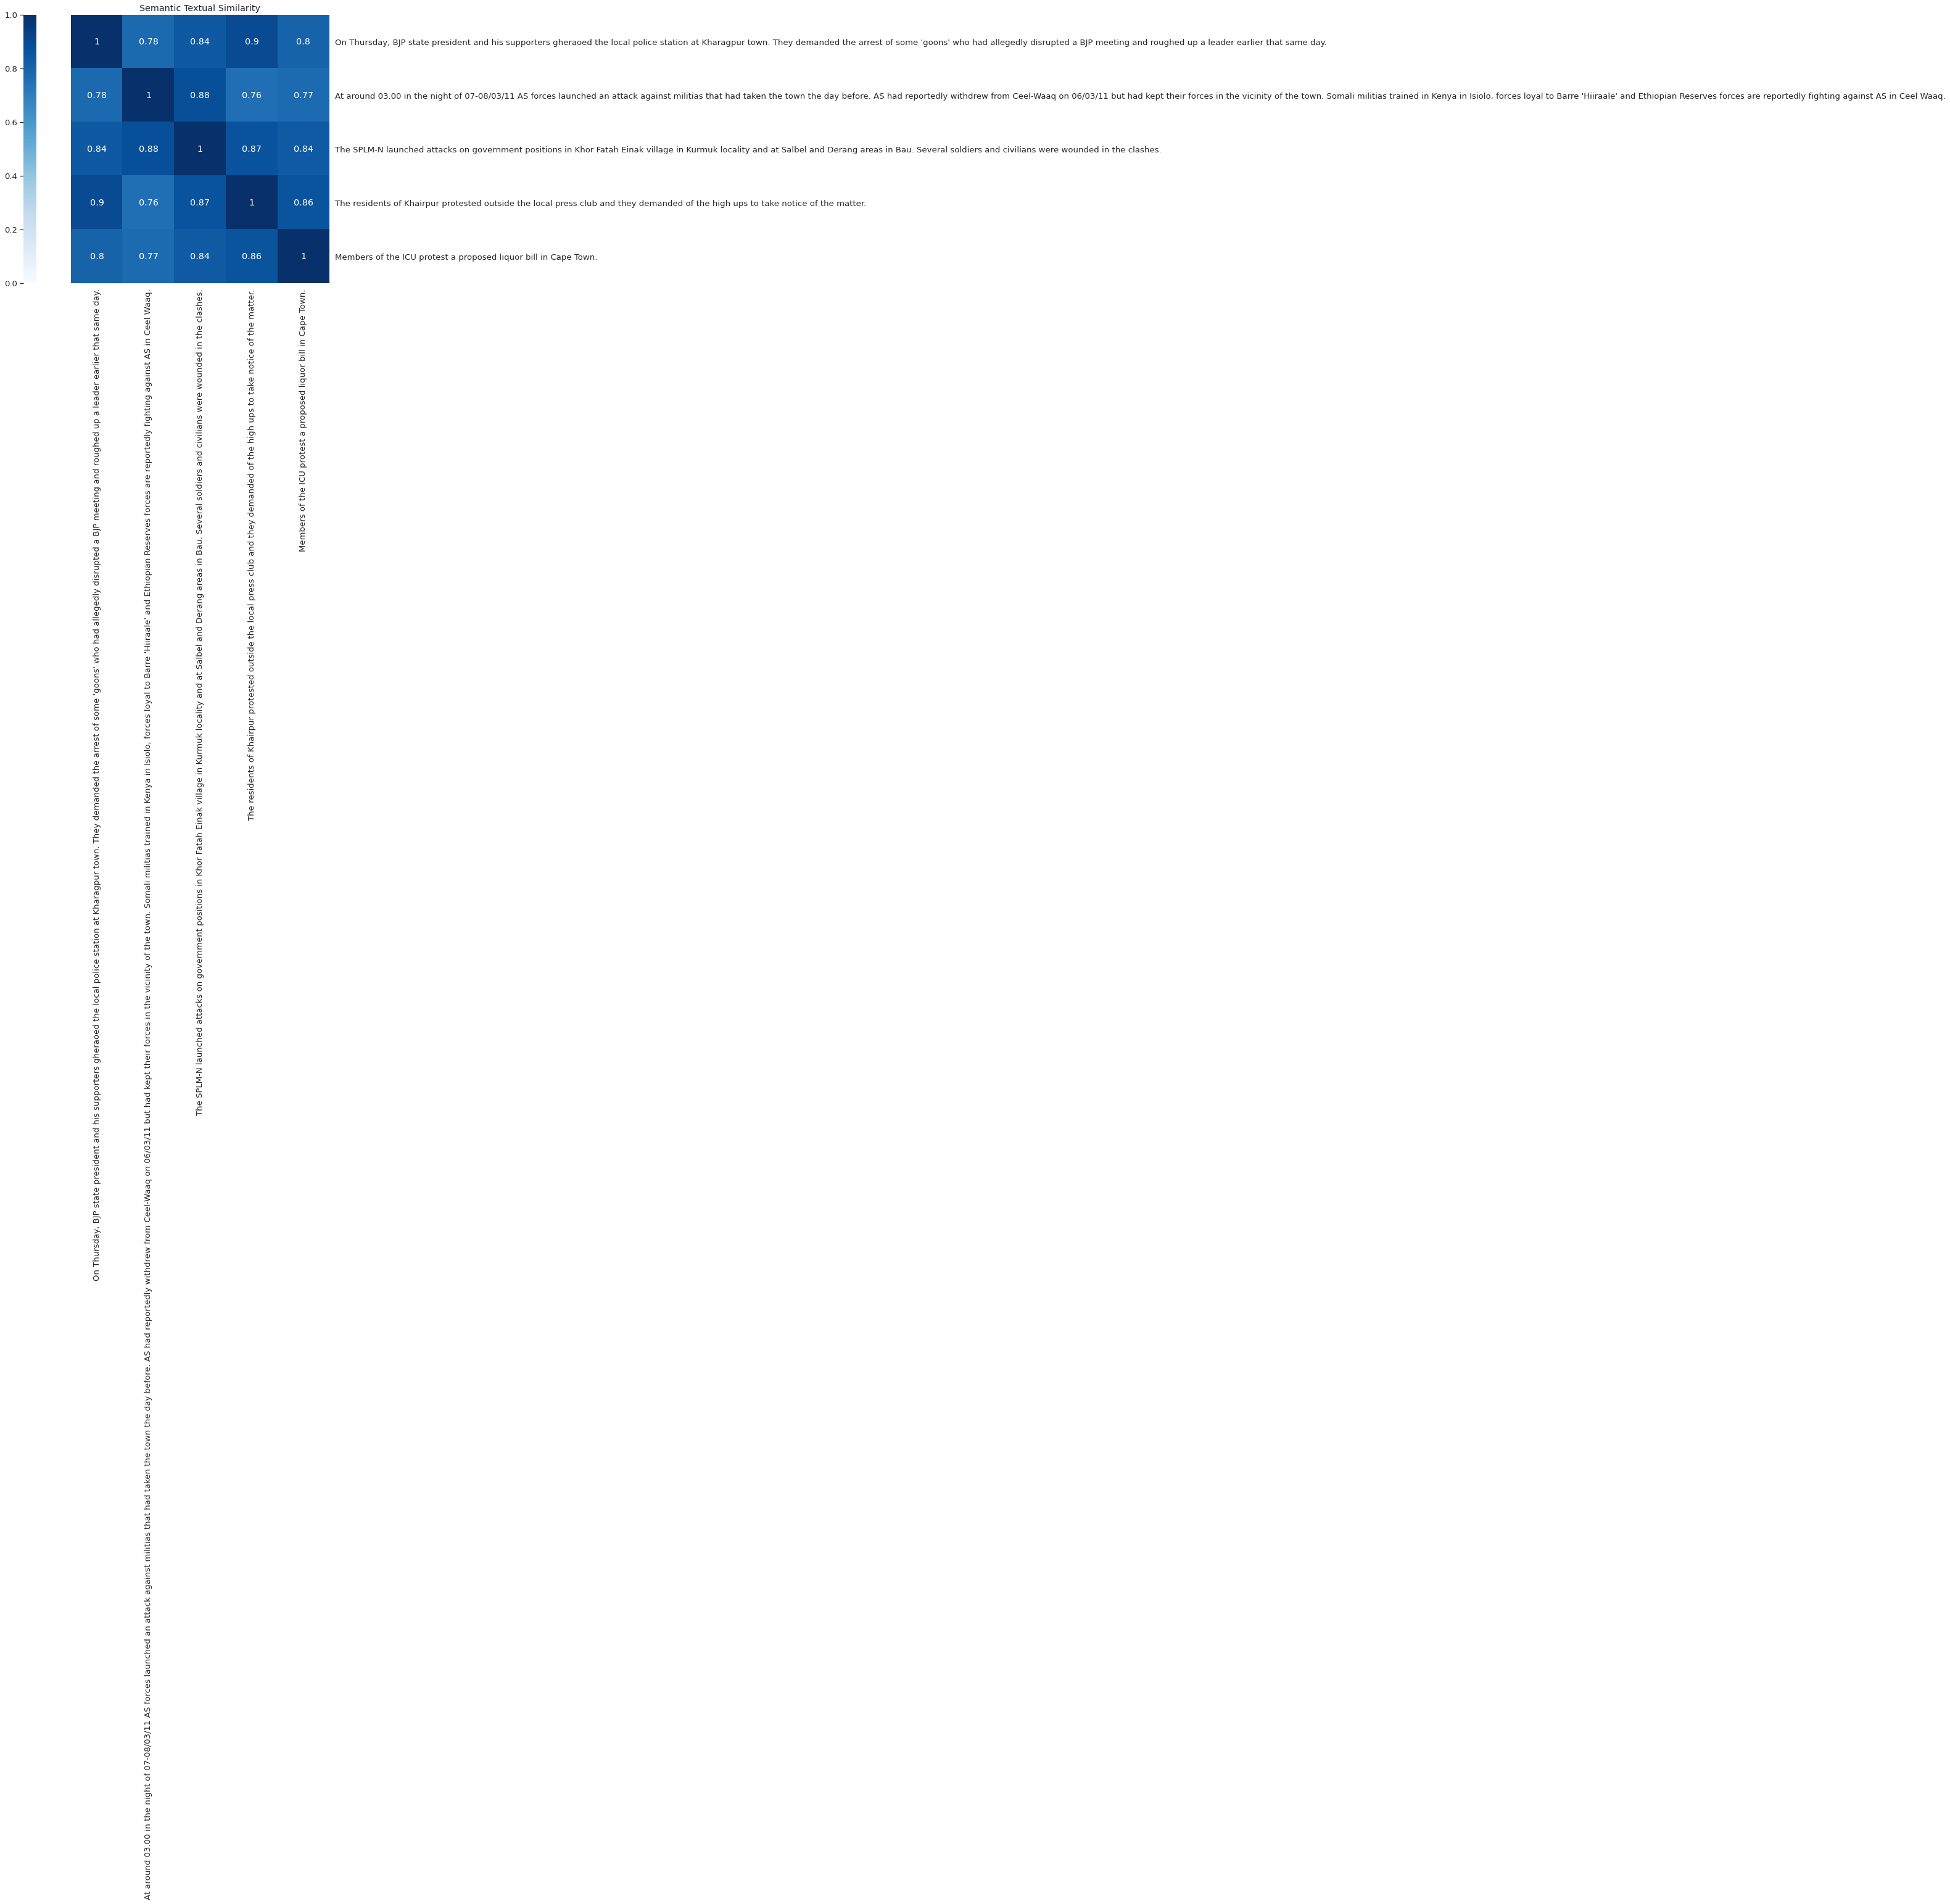

In [ ]:
plot_similarity(get_embeddings(notes_train[-5:]), notes_train[-5:])

In [ ]:
notes_train[-5:]

19995    On Thursday, BJP state president and his suppo...
19996    At around 03.00 in the night of 07-08/03/11 AS...
19997    The SPLM-N launched attacks on government posi...
19998    The residents of Khairpur protested outside th...
19999    Members of the ICU protest a proposed liquor b...
Name: NOTES, dtype: object

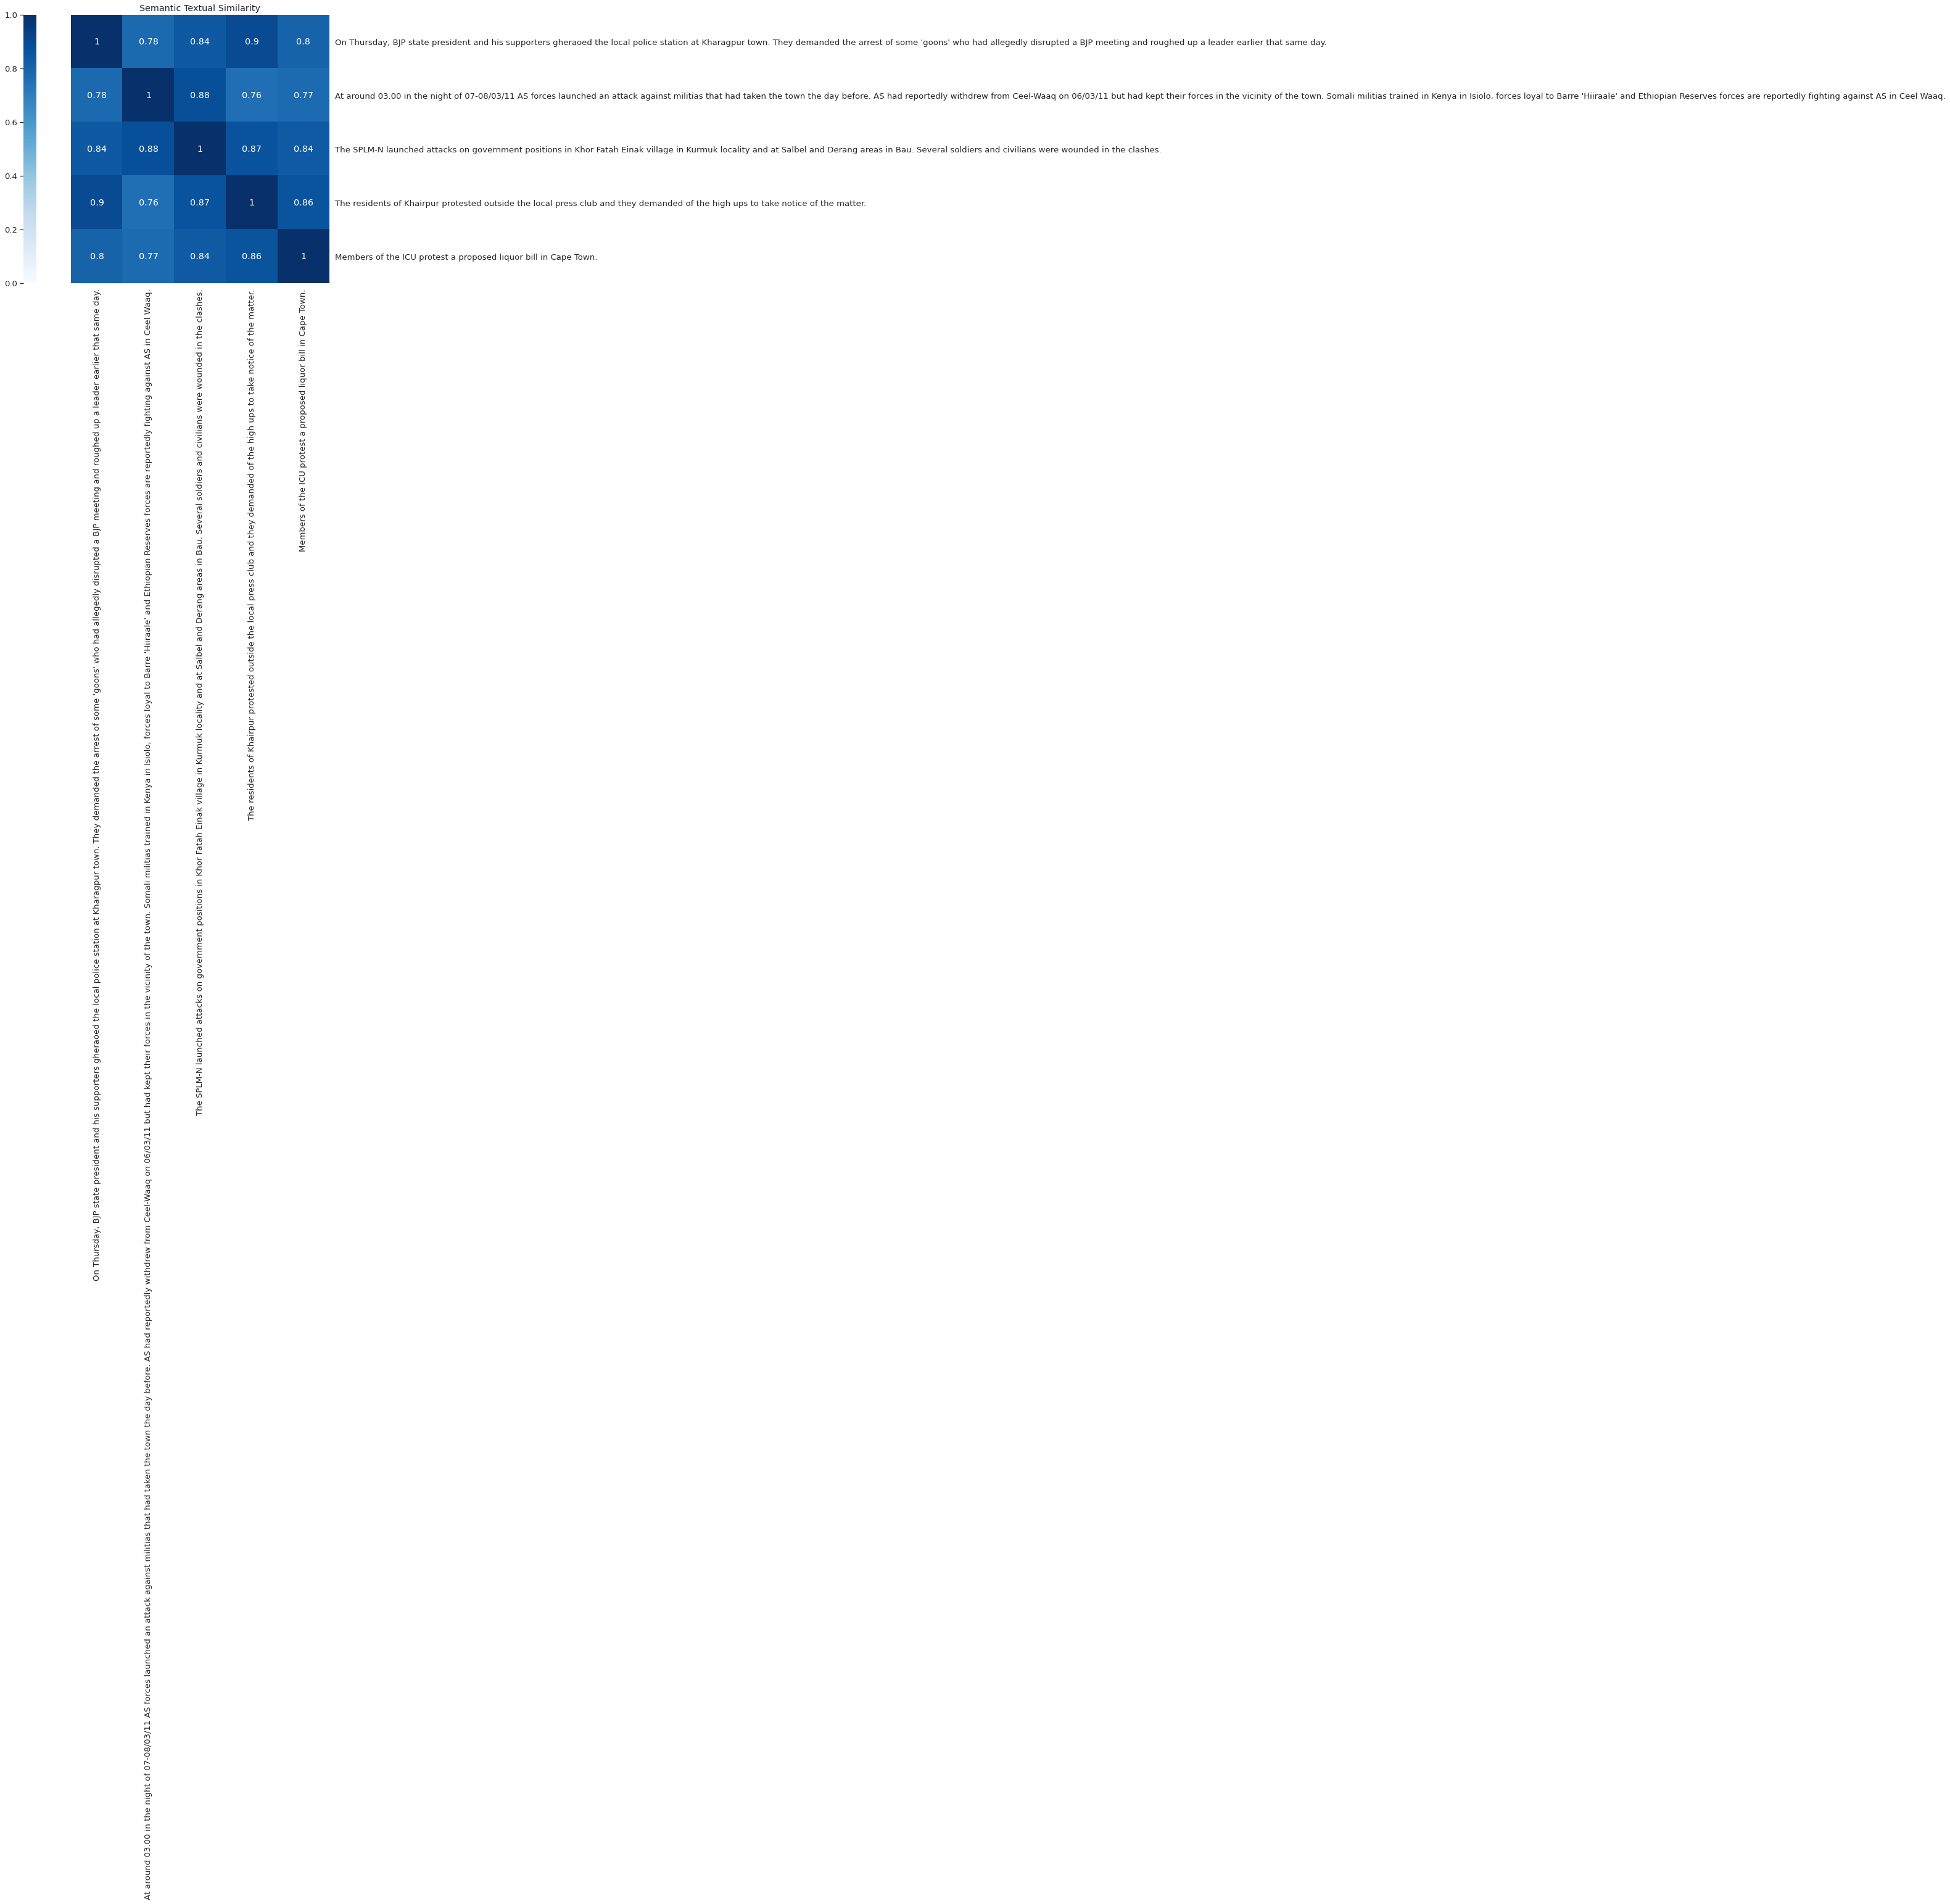

In [ ]:
# reviews = ["il libro è interessante",
#            "il romanzo è interessante",
#            "nel mezzo del cammin di nostra vita"]



plot_similarity(get_embeddings(notes_train[-5:]), notes_train[-5:])

## Classifier Model

### Metrics

In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### Model

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

### Training

## sub event 

In [ ]:
# Target
event_type_int_map = {s: idx for idx, s in enumerate(df_train['SUB_EVENT_TYPE'].factorize()[1])}
print(event_type_int_map)
num_classes = len(event_type_int_map)
df_train['SUB_EVENT_TYPE'] = df_train['SUB_EVENT_TYPE'].replace(event_type_int_map)
df_valid['SUB_EVENT_TYPE'] = df_valid['SUB_EVENT_TYPE'].replace(event_type_int_map)

# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
target_train = tf.keras.utils.to_categorical(df_train['SUB_EVENT_TYPE'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['SUB_EVENT_TYPE'].values, num_classes=num_classes)

{'Remote explosive/landmine/IED': 0, 'Attack': 1, 'Armed clash': 2, 'Agreement': 3, 'Violent demonstration': 4, 'Peaceful protest': 5, 'Mob violence': 6, 'Sexual violence': 7, 'Protest with intervention': 8, 'Arrests': 9, 'Grenade': 10, 'Abduction/forced disappearance': 11, 'Disrupted weapons use': 12, 'Government regains territory': 13, 'Air/drone strike': 14, 'Non-state actor overtakes territory': 15, 'Excessive force against protesters': 16, 'Shelling/artillery/missile attack': 17, 'Suicide bomb': 18, 'Headquarters or base established': 19, 'Looting/property destruction': 20, 'Change to group/activity': 21, 'Non-violent transfer of territory': 22, 'Other': 23}


In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 163s 258ms/step - loss: 1.4956 - accuracy: 0.5841 - balanced_recall: 0.0666 - balanced_precision: 0.0933 - balanced_f1_score: 0.0765 - val_loss: 1.3191 - val_accuracy: 0.5654 - val_balanced_recall: 0.0503 - val_balanced_precision: 0.0724 - val_balanced_f1_score: 0.0583
Epoch 2/5
607/607 [==============================] - 152s 251ms/step - loss: 1.1565 - accuracy: 0.6271 - balanced_recall: 0.1012 - balanced_precision: 0.1275 - balanced_f1_score: 0.1121 - val_loss: 1.1851 - val_accuracy: 0.6067 - val_balanced_recall: 0.0687 - val_balanced_precision: 0.0832 - val_balanced_f1_score: 0.0743
Epoch 3/5
607/607 [==============================] - 160s 264ms/step - loss: 1.0704 - accuracy: 0.6426 - balanced_recall: 0.1183 - balanced_precision: 0.1431 - balanced_f1_score: 0.1288 - val_loss: 1.1219 - val_accuracy: 0.6219 - val_balanced_recall: 0.0789 - val_balanced_precision: 0.0979 - val_balanced_f1_score: 0.0864
Epoch 4/5
607/607 [============

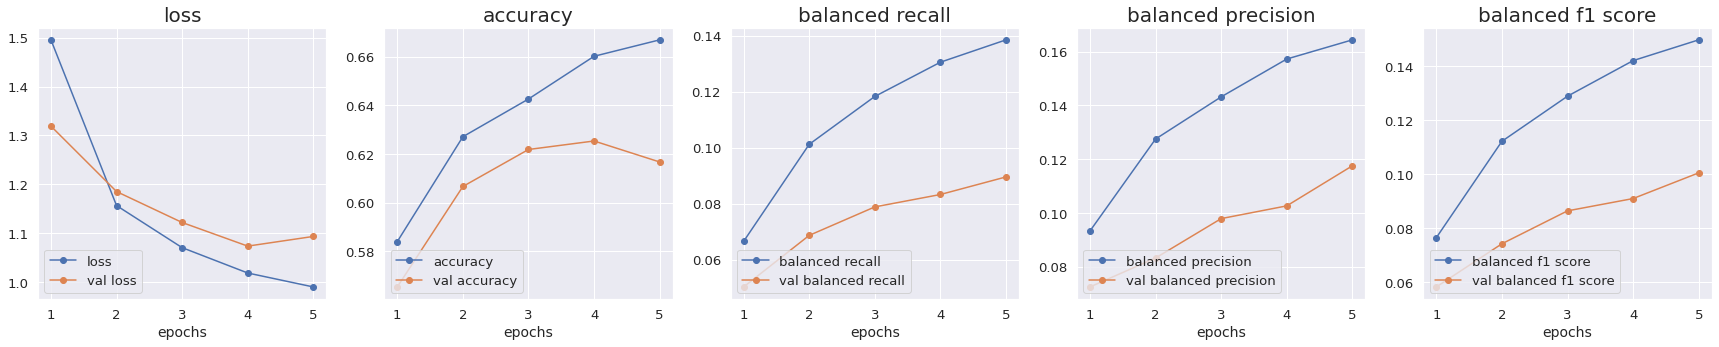

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

## Fatalities: Regression

In [ ]:
# Target
target_train = df_train['FATALITIES'].astype('float')
target_valid = df_valid['FATALITIES'].astype('float')

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
    loss='mean_absolute_error', metrics=METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 171s 276ms/step - loss: 5.4144 - mean_squared_error: 1802.4746 - val_loss: 5.8913 - val_mean_squared_error: 718.5144
Epoch 2/5
607/607 [==============================] - 153s 253ms/step - loss: 5.4144 - mean_squared_error: 1802.4746 - val_loss: 5.8913 - val_mean_squared_error: 718.5144
Epoch 3/5
607/607 [==============================] - 154s 254ms/step - loss: 5.4144 - mean_squared_error: 1802.4738 - val_loss: 5.8913 - val_mean_squared_error: 718.5144
Epoch 4/5
607/607 [==============================] - 153s 253ms/step - loss: 5.4144 - mean_squared_error: 1802.4747 - val_loss: 5.8913 - val_mean_squared_error: 718.5144


In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
    loss='mean_absolute_error', metrics=METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 173s 258ms/step - loss: 1.0230 - accuracy: 0.6056 - balanced_recall: 0.3200 - balanced_precision: 0.4655 - balanced_f1_score: 0.3744 - val_loss: 0.8787 - val_accuracy: 0.6289 - val_balanced_recall: 0.2801 - val_balanced_precision: 0.3730 - val_balanced_f1_score: 0.3161
Epoch 2/5
607/607 [==============================] - 154s 254ms/step - loss: 0.7936 - accuracy: 0.6946 - balanced_recall: 0.4738 - balanced_precision: 0.6066 - balanced_f1_score: 0.5294 - val_loss: 0.7650 - val_accuracy: 0.6919 - val_balanced_recall: 0.3418 - val_balanced_precision: 0.4377 - val_balanced_f1_score: 0.3801
Epoch 3/5
607/607 [==============================] - 154s 254ms/step - loss: 0.7478 - accuracy: 0.7140 - balanced_recall: 0.5105 - balanced_precision: 0.6355 - balanced_f1_score: 0.5640 - val_loss: 0.7878 - val_accuracy: 0.6693 - val_balanced_recall: 0.3466 - val_balanced_precision: 0.4405 - val_balanced_f1_score: 0.3841
Epoch 4/5
607/607 [============